# **Homogeneous 1 – D wave equation (pulsating cord)**:
# $ u_{tt} - 4u_{xx} - xt = 0, \qquad 0 < x < \pi, \quad 0<t<1, \quad u = u(x,t)$

## 1. Boundary conditions (Dirichlet):
* $\quad u(0, t) = u(\pi, t) = 0 \qquad 0 \leq t \leq 1$

## 2. Initial conditions:
* $ u(x, 0) = sin(2x) \qquad 0 \leq x \leq \pi$
* $ u_t(x, 0) = \frac{31}{8}sin(2x) - \frac{257}{32}sin(4x) \qquad 0 \leq x \leq \pi$

## *ANALYTICAL SOLUTION*
## $ u(x, t) = sin(2x) \left( cos(4t) + sin(4t) \right) - sin(4x)sin(8t) $

# ====================== OR =========================

# $ u_{tt} - \frac{4}{\pi^2} u_{xx} - \pi xt = 0, \qquad 0 < x < 1, \quad 0<t<1, \quad u = u(x,t)$

## 1. Boundary conditions (Dirichlet):
* $\quad u(0, t) = u(1, t) = 0 \qquad 0 \leq t \leq 1$

## 2. Initial conditions:
* $ u(x, 0) = sin(2\pi x) \qquad 0 \leq x \leq 1$
* $ u_t(x, 0) = \frac{31}{8}sin(2\pi x) - \frac{257}{32}sin(4\pi x) \qquad 0 \leq x \leq 1$

## *ANALYTICAL SOLUTION*
## $ u(x, t) = sin(2\pi x) \left( cos(4t) + sin(4t) \right) - sin(4\pi x)sin(8t) $

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from torch.utils.data import Dataset, DataLoader
from scipy.stats import qmc
from scipy.io import loadmat

# Helpers

## Plots

In [5]:
def plot3D(x,t,y):
  # x_plot =x.squeeze(1)
  # t_plot =t.squeeze(1)
  # X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  # cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  cp = ax.contourf(t,x, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(t, x, F_xt,cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

## PINN

In [6]:
class FeedForward(nn.Module):
  def __init__(self,
               layers,
               activation=nn.ReLU(),
               weight_init=None,
               bias_init=None):

    super().__init__()
    self.n_layers = len(layers) - 1
    self.layers = layers
    self.activation = activation
    self.weight_init = weight_init
    self.bias_init = bias_init

    dense_layers = [
        self.dense_layer(in_features=self.layers[i],
                         out_features=self.layers[i+1])
        for i in range(self.n_layers - 1)]
    dense_layers.append(nn.Linear(in_features=self.layers[-2],
                                  out_features=self.layers[-1]))

    self.feed_forward = nn.Sequential(*dense_layers)

  def dense_layer(self, in_features, out_features):
    dense_layer = nn.Sequential(
      nn.Linear(in_features=in_features,
                out_features=out_features),
    )

    if self.weight_init is not None:
        self.weight_init(dense_layer[0].weight)

    if self.bias_init is not None:
        self.bias_init(dense_layer[0].bias)

    dense_layer.add_module("activation", self.activation)
    return dense_layer

  def forward(self, x):
    return self.feed_forward(x)

In [7]:
class PINN():
  def __init__(self, XT_c,
               XT_IC, u_IC, u_t_IC,
               XT_l, XT_r, u_BC,
               XT_test, v,
               layers,
               epochs,
               patience,
               chkpt_path='model.pth',
               activation=nn.ReLU(),
               loss='mse',
               dtype=torch.float32,
               device='cpu'):

    super().__init__()

    # Some constants
    self.device = device
    self.dtype = dtype
    self.v = torch.tensor(v, dtype=dtype, device=device)
    self.pi = torch.tensor(np.pi, dtype=dtype, device=device)
    self.u_IC = torch.tensor(u_IC, dtype=dtype, device=device)
    self.u_t_IC = torch.tensor(u_t_IC, dtype=dtype, device=device)
    self.u_BC = torch.tensor(u_BC, dtype=dtype, device=device)
    self.XT_c = torch.tensor(XT_c, dtype=dtype, device=device)
    self.XT_IC = torch.tensor(XT_IC, dtype=dtype, device=device)
    self.XT_l = torch.tensor(XT_l, dtype=dtype, device=device)
    self.XT_r = torch.tensor(XT_r, dtype=dtype, device=device)
    self.XT_test = torch.tensor(XT_test, dtype=dtype, device=device)
    self.epochs = epochs
    self.chkpt_path = chkpt_path
    self.patience = patience

    # Neural network
    # self.feed_forward = FeedForward(layers=layers, activation=activation)
    self.feed_forward = FeedForward(layers=layers,
                                    activation=activation,
                                    weight_init=lambda m: nn.init.xavier_normal_(m.data, nn.init.calculate_gain('tanh')),
                                    bias_init=lambda m: nn.init.zeros_(m.data))

    # Loss function
    if loss == 'mse':
      self.loss_fn = nn.MSELoss()
    elif loss == 'mae':
      self.loss_fn = nn.L1Loss()

    # Setting optimizer
    self.optimizer = torch.optim.LBFGS(self.feed_forward.parameters(),
                                       lr=1,
                                       max_iter=1000,  # max_iter=2000,
                                       max_eval=None,
                                       tolerance_grad=1e-07,
                                       tolerance_change=1e-09,
                                       history_size=100,
                                       line_search_fn='strong_wolfe')  # None or 'strong_wolfe'

  def calculate_u(self, xt):
    return self.feed_forward(xt)

  def calculate_dudt(self, XT):
    x = XT[:, 0].clone().detach()
    t = XT[:, 1].clone().detach().requires_grad_(True)

    u = self.calculate_u(torch.cat((x.view(-1, 1), t.view(-1, 1)), dim=1))

    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        # retain_graph=True,
        create_graph=True
    )[0]

    return u_t

  def calculate_f(self, XT):
    x = XT[:, 0].clone().detach().requires_grad_(True)
    t = XT[:, 1].clone().detach().requires_grad_(True)

    u = self.calculate_u(torch.cat((x.view(-1, 1), t.view(-1, 1)), dim=1))

    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_tt = torch.autograd.grad(
        u_t, t,
        grad_outputs=torch.ones_like(u_t),
        retain_graph=True,
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    x = x.flatten().requires_grad_(False)
    t = t.flatten().requires_grad_(False)

    f_hat = u_tt - self.v * u_xx - self.pi * x * t

    return f_hat

  def loss_BC(self):
    ul_hat = self.calculate_u(self.XT_l)
    ur_hat = self.calculate_u(self.XT_r)
    loss_BC = self.loss_fn(ul_hat.flatten(), self.u_BC) + self.loss_fn(ur_hat.flatten(), self.u_BC)
    return loss_BC

  def loss_IC(self):
    u_IC_hat = self.calculate_u(self.XT_IC)
    u_t_IC_hat = self.calculate_dudt(self.XT_IC)
    loss_IC = self.loss_fn(u_IC_hat.flatten(), self.u_IC) + self.loss_fn(u_t_IC_hat.flatten(), self.u_t_IC)
    return loss_IC

  def loss_c(self):
    f_hat = self.calculate_f(self.XT_c)
    return self.loss_fn(f_hat.flatten(), torch.zeros(f_hat.shape[0]))

  def train_loss(self):
    train_loss = self.loss_BC() + self.loss_IC() + self.loss_c()
    return train_loss

  def test_loss(self):
    f_hat = self.calculate_f(self.XT_test)
    return self.loss_fn(f_hat.flatten(), torch.zeros(f_hat.shape[0]))

  def closure(self):
    train_loss = self.train_loss()
    self.optimizer.zero_grad()
    train_loss.backward()
    return train_loss.detach().item()

  def train(self, print_per_epochs):
    t0 = pd.Timestamp.now()
    self.feed_forward.train()
    train_losses = list()
    test_losses = list()
    for epoch in tqdm(range(self.epochs)):
      flag = 0
      train_loss_BC = self.loss_BC().detach().item()
      train_loss_IC = self.loss_IC().detach().item()
      train_loss_c = self.loss_c().detach().item()
      train_loss = self.optimizer.step(self.closure)
      test_loss = self.test_loss().detach().item()
      train_losses.append(train_loss)
      test_losses.append(test_loss)
      if epoch == 0:
        best_val_loss = test_loss
        best_epoch = -1
        self.checkpoint()
        flag = 1
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BC: {train_loss_BC} | Loss_IC: {train_loss_IC} | Loss_C: {train_loss_c} | Loss: {train_loss} | Test loss: {test_loss} - *Checkpoint*")
      else:
        if test_loss < best_val_loss:
          best_val_loss = test_loss
          best_epoch = epoch
          self.checkpoint()
          flag = 1
          if epoch % print_per_epochs == 0:
            print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BC: {train_loss_BC} | Loss_IC: {train_loss_IC} | Loss_C: {train_loss_c} | Loss: {train_loss} | Test loss: {test_loss} - *Checkpoint*")
        elif epoch - best_epoch > self.patience:
          if epoch % print_per_epochs == 0:
            print(f"\nEarly stopping applied at epoch {epoch}.")
          break
      if (flag == 0) and (epoch % print_per_epochs == 0):
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BC: {train_loss_BC} | Loss_IC: {train_loss_IC} | Loss_C: {train_loss_c} | Loss: {train_loss} | Test loss: {test_loss}")

    print(f"\nTOTAL TRAINING TIME: ")
    self.timer(t0, pd.Timestamp.now())

    return train_losses, test_losses

  def checkpoint(self):
    torch.save({
      "optimizer": self.optimizer.state_dict(),
      "model": self.feed_forward.state_dict()
    }, self.chkpt_path)

  def timer(self, start, end):
    dt = pd.Timedelta(end - start)
    seconds = dt.seconds
    minutes = seconds / 60.
    hours = seconds / 3600.
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

# DATA GENERATION

In [22]:
# ============================= TRAINING DATA =============================
x_min, x_max = 0, 1
t_min, t_max = 0, 1

# **************  Create collocation points ******************
# --- Random Grid ---
Nc = 20_000
XT_c = qmc.scale(qmc.LatinHypercube(2).random(Nc), [x_min, t_min], [x_max, t_max])

# ********************* Initial condition (t=0) **********************************
# 1. u(x,0) = sin(2πx)
# 2. u_t(x,0) = (31/8)*sin(2πx) - (257/32)*sin(4πx)

N_IC = 10_000
x_IC = np.linspace(x_min, x_max, N_IC)
t_IC = np.zeros(N_IC)

XT_IC = np.concatenate((x_IC.reshape(-1, 1), t_IC.reshape(-1, 1)), axis=1)

u_IC = np.sin(2*np.pi*x_IC)
u_t_IC = (31/8) * np.sin(2*np.pi*x_IC) - (257/32) * np.sin(4*np.pi*x_IC)

# ************** Boundary Conditions (x=0 or x=1: u(0,t)=u(1,t)=0) ***************
N_BC = 10_000
x_l = np.zeros(N_BC)
x_r = np.ones(N_BC)
t_BC = np.linspace(t_min, t_max, N_BC)

XT_l = np.concatenate((x_l.reshape(-1, 1), t_BC.reshape(-1, 1)), axis=1)
XT_r = np.concatenate((x_r.reshape(-1, 1), t_BC.reshape(-1, 1)), axis=1)

u_BC = np.zeros(N_BC)
# **********************************************************************

print(XT_c.shape)
print(XT_IC.shape, u_IC.shape, u_t_IC.shape)
print(XT_l.shape, XT_r.shape, u_BC.shape)

# ============================= VALIDATION DATA =============================
# --- Uniform Grid ---
Nx_c, Nt_c = 100, 100
xc = np.linspace(x_min, x_max, Nx_c)
tc = np.linspace(t_min, t_max, Nt_c)
X_mesh, T_mesh = np.meshgrid(xc, tc)
XT_test = np.concatenate((X_mesh.flatten().reshape(-1, 1), T_mesh.flatten().reshape(-1, 1)), axis=1)

print(XT_test.shape)

(20000, 2)
(10000, 2) (10000,) (10000,)
(10000, 2) (10000, 2) (10000,)
(10000, 2)


# TRAIN

In [23]:
EPOCHS = 100
PATIENCE = 10
N_HIDDEN_LAYERS = 3
HIDDEN_LAYER_SIZE = 256
LAYERS = [2] + N_HIDDEN_LAYERS * [HIDDEN_LAYER_SIZE] + [1]
PATH = "model.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

pinn = PINN(
    XT_c=XT_c, XT_IC=XT_IC, u_IC=u_IC, u_t_IC=u_t_IC,
    XT_l=XT_l, XT_r=XT_r, u_BC=u_BC, XT_test=XT_test,
    v=4/(np.pi**2),
    layers=LAYERS,
    epochs=EPOCHS,
    patience=PATIENCE,
    activation=nn.Tanh(),
    loss='mse',
)

train_loss, test_loss = pinn.train(print_per_epochs=1)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100 | Loss_BC: 0.006361396051943302 | Loss_IC: 40.25867462158203 | Loss_C: 1.1131689548492432 | Loss: 41.37820816040039 | Test loss: 0.0034966743551194668 - *Checkpoint*
Epoch: 2/100 | Loss_BC: 0.06501119583845139 | Loss_IC: 0.039005346596241 | Loss_C: 0.0028953764121979475 | Loss: 0.10691192001104355 | Test loss: 0.0017022117972373962 - *Checkpoint*
Epoch: 3/100 | Loss_BC: 0.001169217866845429 | Loss_IC: 0.0008197340066544712 | Loss_C: 0.0013905838131904602 | Loss: 0.0033795356284826994 | Test loss: 0.0002208325604442507 - *Checkpoint*
Epoch: 4/100 | Loss_BC: 0.00010819471208378673 | Loss_IC: 0.00021552898397203535 | Loss_C: 0.00017524848226457834 | Loss: 0.0004989721928723156 | Test loss: 9.469835640629753e-05 - *Checkpoint*
Epoch: 5/100 | Loss_BC: 4.2795240005943924e-05 | Loss_IC: 0.00011474218626972288 | Loss_C: 7.771452510496601e-05 | Loss: 0.00023525196593254805 | Test loss: 5.461950786411762e-05 - *Checkpoint*
Epoch: 6/100 | Loss_BC: 3.348926838953048e-05 | Loss_IC: 9.0

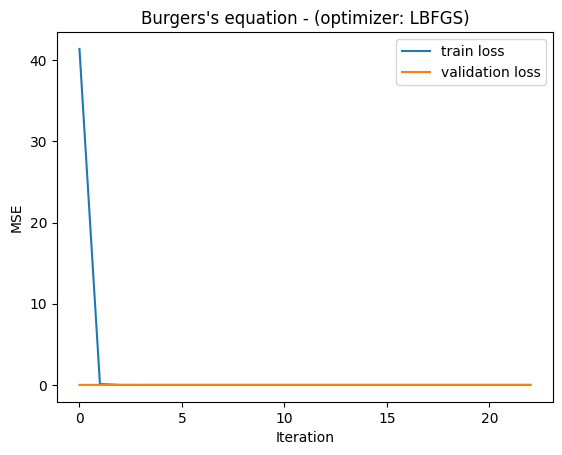

In [24]:
plt.figure()
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='validation loss')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.title("Burgers's equation - (optimizer: LBFGS)")
plt.show()

# INFERENCE

In [25]:
checkpoint = torch.load("model.pth")
pinn.feed_forward.load_state_dict(checkpoint['model'])

with torch.inference_mode():
  u_pred = pinn.feed_forward.forward(torch.tensor(XT_test, dtype=torch.float32)).detach().cpu().numpy()

u_test = list()
for i in range(XT_test.shape[0]):
  x, t = XT_test[i, 0], XT_test[i, 1]
  u_test.append(np.sin(2*np.pi*x) * (np.cos(4*t) + np.sin(4*t)) - np.sin(4*np.pi*x) * np.sin(8*t))

u_test = np.array(u_test)
u_pred = u_pred.flatten()

test_error = u_test - u_pred
test_nmse = np.linalg.norm(u_test - u_pred, 2) / np.linalg.norm(u_test, 2)
print(f'Test error: {test_nmse}')

Test error: 0.09097098548132096


In [26]:
x = XT_test[:, 0].flatten()
t = XT_test[:, 1].flatten()

df = pd.DataFrame(
    {
        't': t,
        'x': x,
        'u_real': u_test.flatten(),
        'u': u_pred.flatten()
    }
)
df['abs_error'] = abs(df['u_real'] - df['u'])
df.to_csv('pinn.csv', index=False)

In [27]:
df.sort_values(by='abs_error', ascending=False).head()

,t,x,u_real,u,abs_error
9954,1.0,0.545455,-0.137519,0.134349,0.271868
9955,1.0,0.555556,-0.153546,0.118278,0.271824
9953,1.0,0.535354,-0.114485,0.156734,0.271219
9956,1.0,0.565657,-0.161283,0.109885,0.271169
9957,1.0,0.575758,-0.159604,0.110459,0.270063


In [28]:
test_error.shape

(10000,)

# PLOTS

In [29]:
xc.shape

(100,)

In [30]:
u_pred = u_pred.reshape(len(xc), len(tc))
u_test = u_test.reshape(len(xc), len(tc))

In [31]:
u_test.shape

(100, 100)

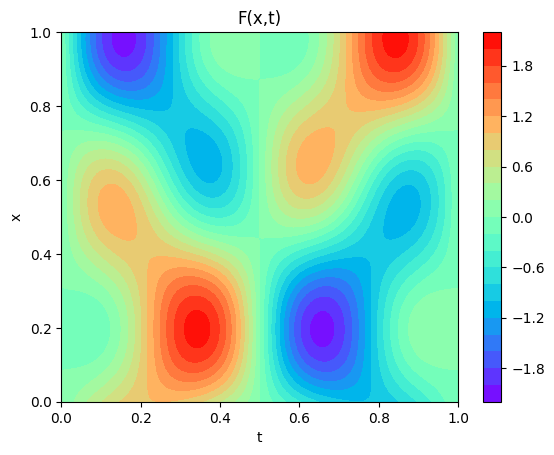

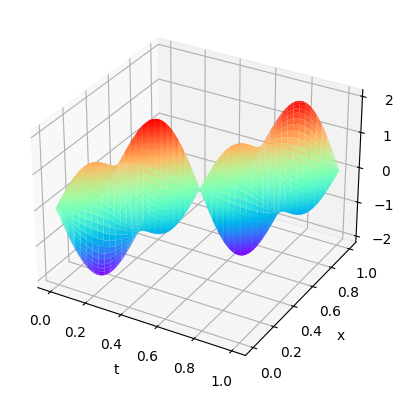

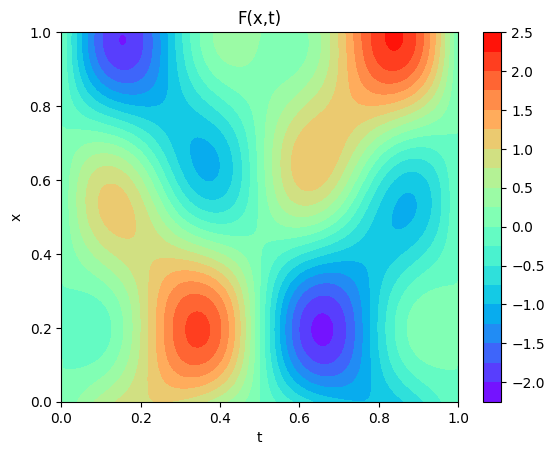

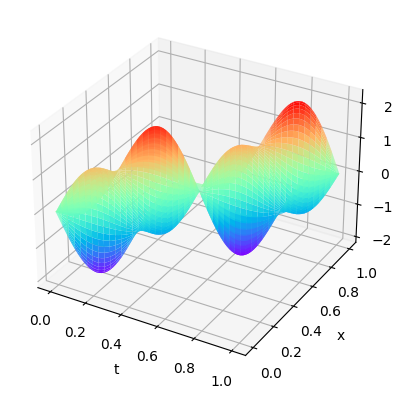

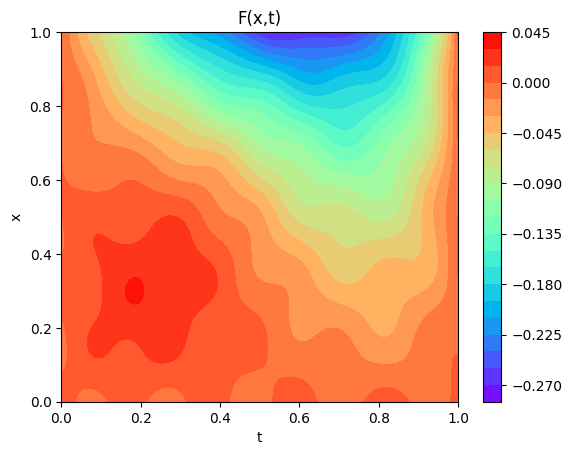

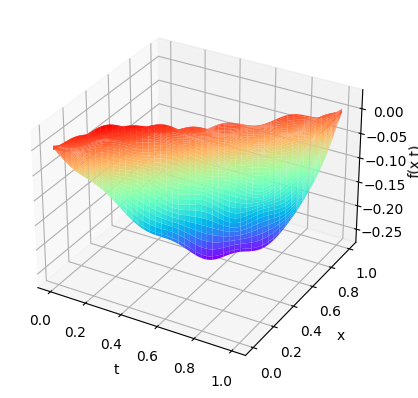

In [32]:
plot3D(xc, tc, u_test)
plot3D(xc, tc, u_pred)
plot3D(xc, tc, test_error.reshape(len(xc), len(tc)))

# Check first derivatives...

In [33]:
checkpoint = torch.load("model.pth")
pinn.feed_forward.load_state_dict(checkpoint['model'])

XT_test = torch.tensor(XT_test, dtype=torch.float32)

x_test = XT_test[:, 0].flatten()
x_test.requires_grad = True

t_test = XT_test[:, 1].flatten()
t_test.requires_grad = True

u_pred = pinn.feed_forward.forward(torch.cat((x_test.view(-1, 1), t_test.view(-1, 1)), dim=1)).flatten()

u_pred_x = torch.autograd.grad(u_pred, x_test, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
u_pred_t = torch.autograd.grad(u_pred, t_test, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]

print(u_pred_x.shape, u_pred_t.shape)

torch.Size([10000]) torch.Size([10000])


In [34]:
u_x = u_pred_x.detach().numpy()
u_t = u_pred_t.detach().numpy()
x = x_test.detach().numpy()
t = t_test.detach().numpy()

grad_u_df = pd.DataFrame(
  {
      'x': x,
      't': t,
    'u_x': u_x,
    'u_t': u_t,
    'grad_abs_2': np.sqrt(u_x ** 2 + u_t ** 2)
  }
)

df_sorted = grad_u_df.sort_values(by='grad_abs_2', ascending=False)

In [35]:
df_sorted

,x,t,u_x,u_t,grad_abs_2
9999,1.000000,1.000000,-23.839933,-0.425249,23.843725
9899,1.000000,0.989899,-23.736919,-0.320769,23.739086
9799,1.000000,0.979798,-23.562244,-0.231734,23.563385
9998,0.989899,1.000000,-23.396088,-0.377910,23.399139
9898,0.989899,0.989899,-23.331942,-0.201193,23.332809
...,...,...,...,...,...
9943,0.434343,1.000000,0.138122,0.017504,0.139227
3199,1.000000,0.313131,-0.121757,-0.035753,0.126898
1907,0.070707,0.191919,-0.057690,-0.110777,0.124899
2092,0.929293,0.202020,-0.077078,-0.092476,0.120386


<Axes: xlabel='x', ylabel='t'>

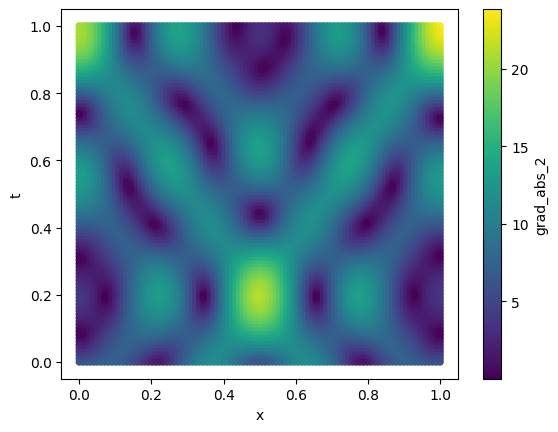

In [36]:
top_N = 20000
top_df = df_sorted.head(top_N)

top_df.plot.scatter(x='x', y='t', c='grad_abs_2')